In [75]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
params = Table.read('line_fit_params.ecsv')

In [3]:
a, m, s = params['AMPLITUDE'], params['MEAN'], params['STDDEV']
mask = a > 0
a, m, s = a[mask], m[mask], s[mask]

In [4]:
for i in range(len(a)):
    if i == 0:
        lines_mod = models.Gaussian1D(a[i], m[i], s[i])
    else:
        lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])

In [5]:
mw = np.arange(1000, 3000, 0.01)

(1170, 1180)

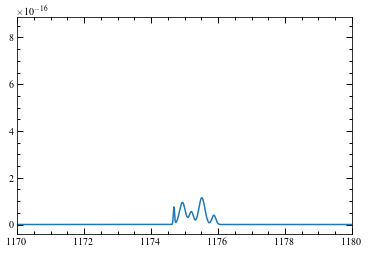

In [6]:
plt.plot(mw, lines_mod(mw))
plt.xlim(1170, 1180)

Yay!

In [133]:
hdul = fits.open('../dem/trappist-1_dem_spectra.fits')

In [134]:
hdul.info()

Filename: ../dem/trappist-1_dem_spectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   400R x 4C   [D, D, D, D]   


In [135]:
data = hdul[1].data

In [136]:
#w, f, e = data['Wavelength'], data['Bin-Integrated Flux'], data['Error']
w, f, bin_el, bin_eu = data['Wavelength'], data['Bin-Integrated Flux'], data['Lower_Error_16'], data['Upper_Error_84']

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


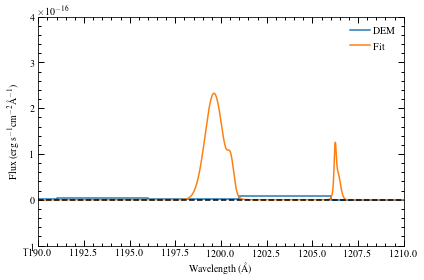

In [11]:
#plt.figure(figsize=(8,5))
plt.step(w,f/5, label = 'DEM')
plt.plot(mw, lines_mod(mw), label ='Fit')
plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
plt.xlim(1190, 1210)
plt.legend()
plt.axhline(0, ls='--', c='k')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
#plt.savefig('mod_eg.png', dpi=150)


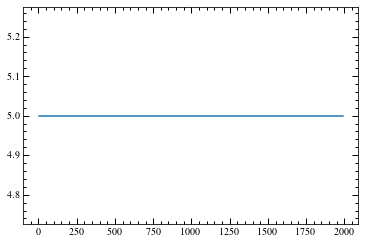

In [12]:
plt.plot(w[:-1], np.diff(w) )

In [13]:
mf = lines_mod(mw)

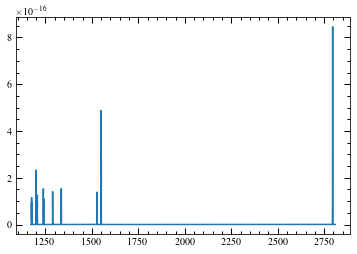

In [14]:
mask = mf >0
plt.step(mw[mask], mf[mask])

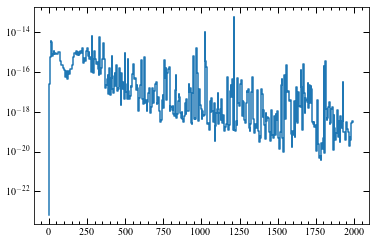

In [15]:
plt.step(w,f)
#plt.xscale('log')
plt.yscale('log')
#plt.plot(mw[mask], mf[mask])

In [16]:
mw = np.arange(w[0], w[-1], 0.01)

In [17]:
mf = lines_mod(mw)

In [18]:
#mask = (w > mw[0]) & (w< mw[-1])
#w2, f2 = w[mask], f[mask]
w2, f2 = resample.bintogrid(w,f, newx=mw)

In [19]:
mf2 = f2+mf

(1237, 1243)

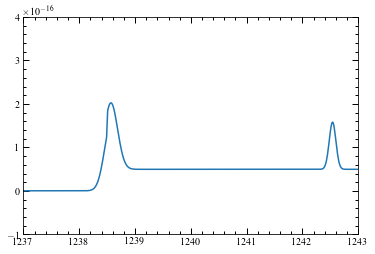

In [20]:
plt.plot(mw, mf2)
plt.ylim(-0.1e-15, 0.4e-15)
plt.xlim(1237, 1243)

Ok that's not going to work. Need to remove the lines from the DEM then add in the fitted lines.

In [21]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                  400 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'Wavelength'                                                          
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'Bin-Integrated Flux'                                                 
TFORM2  = 'D       '        

In [22]:
len(w)

400

In [23]:
demf = 1.790471003124503e-17
fitf = 6.4e-17 #??

In [24]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.concatenate((np.array([diff[0]]), diff)) #adds an extra value to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1


In [25]:
w0, w1 = wavelength_edges(w)

In [26]:
line_edges = [[1174.6,1176.1],[1198.4,1200.95],[1205.9,1206.8],[1238.2,1238.9],[1242.3,1242.75],[1288.5,1288.8],[1333.9, 1334.55],[1334.9,1335.9],[1526.8, 1527.2],[1547.65, 1548.3],[1550.25,1550.75]]

In [27]:
line_width = np.diff(line_edges)

In [28]:
flux_table = Table.read('int_flux_table.ecsv')

In [29]:
fluxes = flux_table['int_flux']
#len(fluxes), len(line_edges)
fluxes *=1e-16

In [30]:
f_nl = f

In [31]:
w_all = np.concatenate((w, w0))
arg1inds = np.argsort(w_all)
w_all = w_all[arg1inds]
w_all[0:19]

array([-1.5,  1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5,
       26. , 28.5, 31. , 33.5, 36. , 38.5, 41. , 43.5])

In [32]:
changed_w = np.array([], dtype=float)
fractions = []
flux_fraction  = np.array([], dtype=float)
for edges, flux in zip(line_edges,fluxes):
    b, r = edges[0], edges[1]
    w0_b = w0[w0 < b]
    bv = np.where(w0 ==w0_b[-1])[0][0]
    w1_r= w1[w1 > r]
    rv = np.where(w1 ==w1_r[0])[0][0]
    overlap_w = np.unique([w[bv], w[rv]])
    changed_w = np.concatenate((changed_w, overlap_w))
    if len(overlap_w) == 1:
        fractions.append(1.0)
        flux_add = [flux]
    else:
        frac1 = (w1[bv] - b)/(r-b)
        frac2 = 1. - frac1
        #print(frac1, frac2)
        flux_add = [flux*frac1, flux*frac2]
    flux_fraction = np.concatenate((flux_fraction, flux_add))
    
print(changed_w)
print(flux_fraction)

[1176. 1196. 1201. 1206. 1236. 1241. 1241. 1286. 1291. 1336. 1336. 1526.
 1546. 1551.]
[6.40535023e-17 1.09388423e-17 2.68001636e-16 3.45670557e-17
 1.93955821e-17 2.58607762e-17 1.61940098e-17 0.00000000e+00
 1.38314057e-17 3.00406694e-17 5.23182725e-17 1.71800142e-17
 8.49309844e-17 4.78138368e-17]


In [33]:
f_nl = f/(w1-w0)
for i in range(len(f_nl)):
    j = 0
    if w[i] in changed_w:
        f_nl[i] = f_nl[i] - flux_fraction[j]
        j+=1
        

(1170.1, 1179.9)

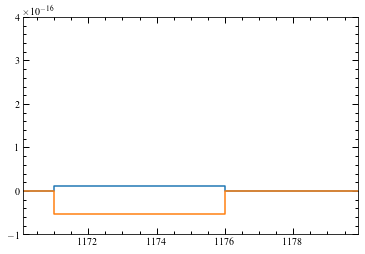

In [34]:
plt.step(w,f/(w1-w0))
plt.step(w, f_nl)
plt.ylim(-0.1e-15, 0.4e-15)
plt.xlim(1170.1, 1179.9)
#plt.xlim(1190, 1210)

In [35]:
w_new = np.arange(0,2000,1)

In [36]:
w_new, f_dem_new = resample.bintogrid(w, f_nl, newx=w_new)

In [37]:
f_lines = lines_mod(w_new)

In [38]:
f_new = f_dem_new + f_lines

(1190, 1210)

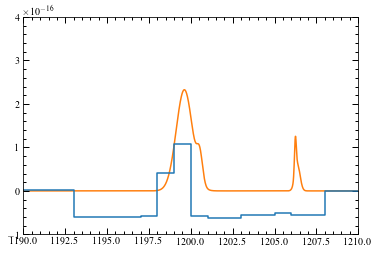

In [39]:
plt.step(w_new, f_new)
plt.plot(mw, lines_mod(mw), zorder=-1)
plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
plt.xlim(1190, 1210)

Hasn't worked, negative values in the DEM. Replace with fit to points either side?

Brief sidetrack - how does dem compare to Linsky? - Need Lya first.

In [40]:
euv = Table.read('../combined/TRAPPIST-1_1Aeuv_estimate.ecsv')

In [41]:
linw, linf = euv['WAVELENGTH'], euv['FLUX']

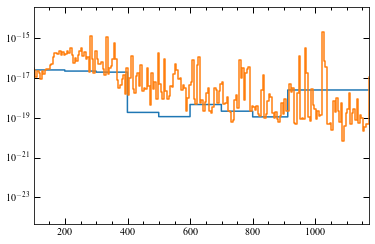

In [42]:
plt.step(linw, linf)
plt.step(w,f/(w1-w0))
plt.xlim(linw[0], linw[-1])#
#plt.ylim(, 1e-15)
plt.yscale('log')

So comparable.

What does the dem look like compared with Phoenix?

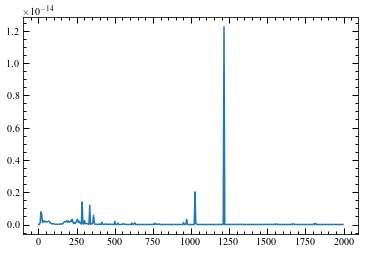

In [43]:
plt.plot(w,f/5)

In [44]:
pmod = Table.read('../optical/scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')

In [45]:
pw, pf = pmod['WAVELENGTH'], pmod['FLUX']

In [46]:
stis_opt = 'odlm41010_sx1.fits'
data = fits.getdata('../combined/'+stis_opt,1)[0]
wo = data['WAVELENGTH']#[dt['DQ']==0]
fo = data['FLUX']#[dt['DQ']==0]
mask = (wo > 4500) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo = wo[mask], fo[mask]

/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


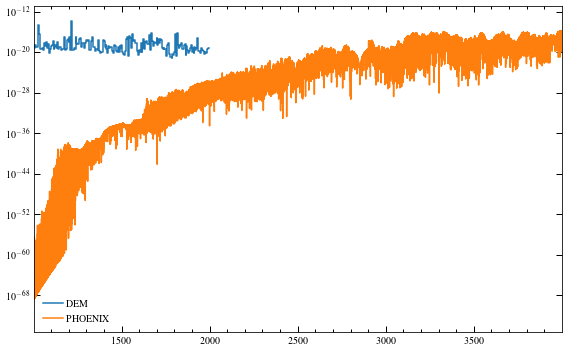

In [47]:
plt.figure(figsize=(8,5))
plt.step(w,f/5, where='mid', label='DEM')
plt.plot(pw, pf, label='PHOENIX')
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()
#plt.savefig('DEMvPHOENIX.png', dpi=150)

So we have a gap.

Can I interpolate onto a 1A grid using scipy? Craftroom didn't work

In [48]:
w1 = np.arange(w[0], w[-1], 1.)
#w1 = np.arange(0, 2001,1)
print(len(w), len(w1))

400 1995


In [49]:
f1 = interp1d(w, f/5, fill_value='extrapolate', kind='nearest')(w1)

(-1e-17, 5e-17)

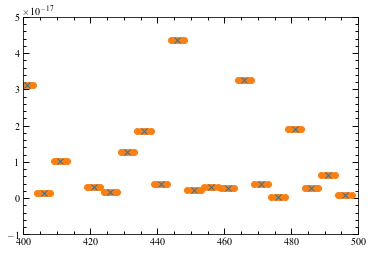

In [50]:
plt.plot(w, f/5, 'x', zorder=10)
plt.plot(w1, f1, 'o')
plt.xlim(400,500)
plt.ylim(-0.1e-16, 0.5e-16)

Yay! Error - have to deal with in some other way as the spectral resolution is not representitive

In [51]:
#savedat = Table([w1*u.AA, f1*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'FLUX'])
#ascii.write(savedat, 'dem_1A.escv', format='ecsv', overwrite=True)

In [52]:
f_add = f1
f_mod = lines_mod(w1)
for i in range(len(w1)):
    if f_mod[i] > 0.0:
        f_add[i] = 0
f_add += f_mod
        

(1190, 1210)

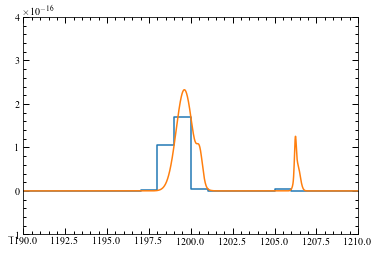

In [53]:
plt.step(w1, f_add)
plt.plot(mw, lines_mod(mw))

plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
plt.xlim(1190, 1210)

In [54]:
hdul = fits.open('../xmm/Trappist-1.fits')

In [55]:
data = hdul[1].data
mdata = hdul[2].data

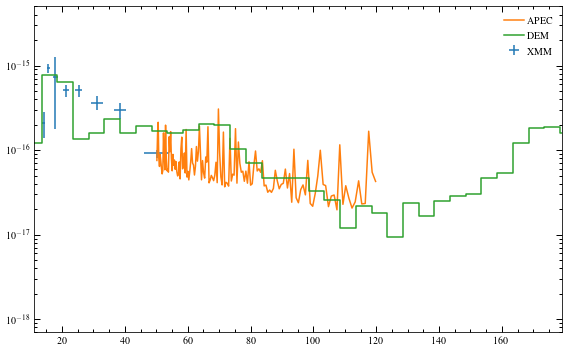

In [56]:
plt.figure(figsize=(8,5))
plt.errorbar(data['WAVE'], data['CFlux'], xerr=data['BIN_WIDTH']/2, yerr = data['CFLUX_err'], ls ='none', label='XMM')
#plt.step(data['WAVE'], data['CFlux'], where='mid', label ='XMM')
mask = mdata['WAVE'] > data['WAVE'][-1]
plt.plot(mdata['WAVE'][mask], mdata['FLUX'][mask], label='APEC')
plt.step(w,f/5, where='mid', label='DEM')
plt.ylim(7e-19, 5e-15)
plt.xlim(11, 179)
plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.savefig('DEMvXMM.png', dpi=150)

In [57]:
#plt.plot(w,f)
g130m = fits.getdata('../COS/test_files/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g130m_v1_component-spec.fits',1)

from astropy.convolution import convolve, Box1DKernel


(-1e-16, 3e-16)

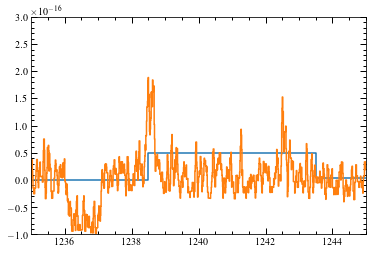

In [58]:
wc, fc = g130m['WAVELENGTH'], g130m['FLUX']
fc = convolve(fc,Box1DKernel(5))
plt.step(w,f, where='mid')
plt.step(wc, fc, where='mid')
plt.xlim(1235, 1245)
plt.ylim(-0.1e-15, 0.3e-15)

20190724 What if we fit a curve to the DEM, then added lines to that?

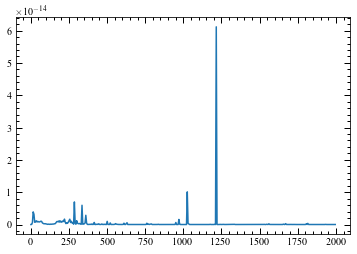

In [59]:
plt.plot(w,f)

In [60]:
#mask = (w < 1200) |(w > 1230)

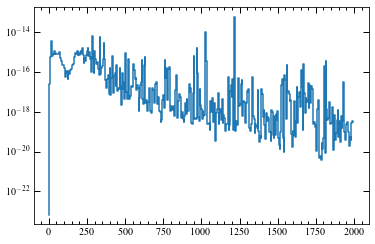

In [61]:
#plt.plot(w[mask], f[mask])
plt.step(w,f, where='mid')
#plt.xscale('log')
plt.yscale('log')
#plt.plot(mw[mask], mf[mask])

In [62]:
from astropy.modeling import models, fitting
fitter = fitting.LinearLSQFitter()
n_init = models.Polynomial1D(3)

In [63]:
mask = w >1000

nfit = fitter(n_init, w[mask],np.log10(f[mask]))

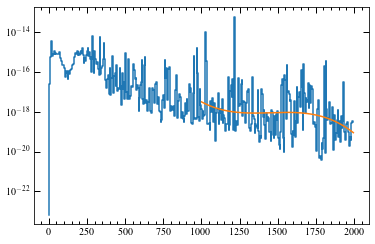

In [64]:

plt.step(w,f, where='mid')
plt.plot(w[mask], 10**nfit(w[mask]))
#plt.xscale('log')
plt.yscale('log')

In [65]:
nfit

<Polynomial1D(3, c0=3.37447937, c1=-0.04471037, c2=0.00003094, c3=-0.00000001)>

In [66]:
#c_new = models.Polynomial1D(2, c0=10**nfit.c0, c1=10**nfit.c1,c2=10**nfit.c2)

In [67]:
#newmod = lines_mod+c_new

NameError: name 'c_new' is not defined

(1090, 1230)

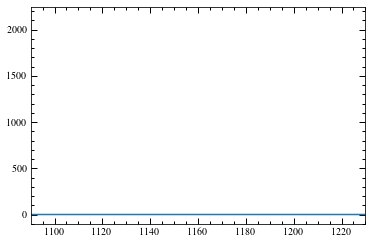

In [68]:
plt.plot(mw, lines_mod(mw)+10**nfit(mw))
plt.xlim(1090, 1230)

In [69]:
#plt.plot(mw, lines_mod(mw))

/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


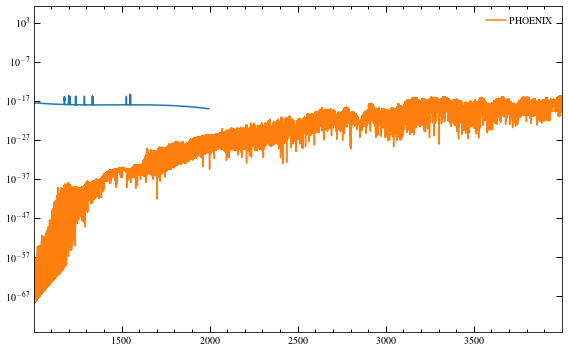

In [70]:
plt.figure(figsize=(8,5))
#plt.step(w,f/5, where='mid', label='DEM')
plt.plot(mw, lines_mod(mw)+10**nfit(mw))
plt.plot(pw, pf, label='PHOENIX')
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()

Hmmm...might have to fit to the COS data?

(1001, 3999)

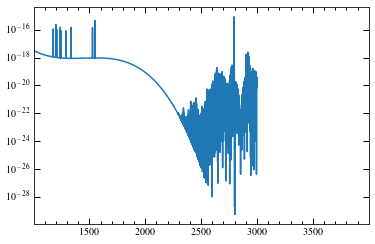

In [71]:
overlap_mask = (pw >=1000) & (pw <= 3000)
overlap_model = lines_mod(pw[overlap_mask]) + 10**nfit(pw[overlap_mask])
overlap_w, overlap_p = pw[overlap_mask], pf[overlap_mask]
combined = overlap_model+overlap_p
plt.plot(overlap_w, combined)
#plt.plot(pw, pf, label='PHOENIX', zorder=-1)
plt.yscale('log')
plt.xlim(1001,3999)

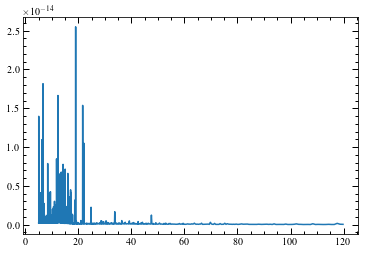

In [72]:
#apec 
apec = fits.getdata('../xmm/Trappist-1.fits',2)
plt.plot(apec['Wave'], apec['FLUX'])

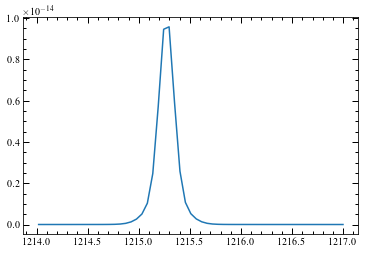

In [73]:
lya = Table.read('../lya/Trappist-1_lya_simple.txt', format='ascii')
plt.plot(lya['WAVELENGTH'], lya['FLUX'])
lyaw, lyaf = lya['WAVELENGTH'], lya['FLUX'] 

(90, 10000)

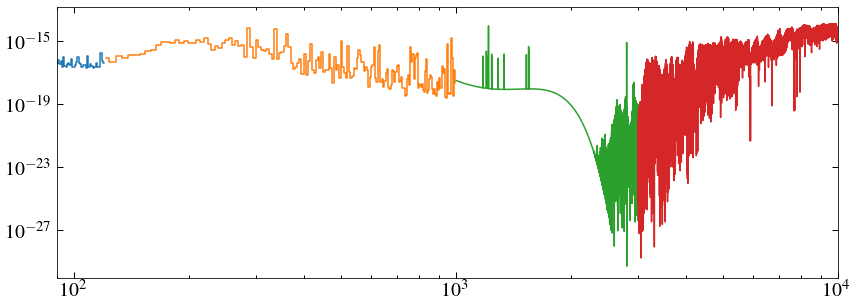

In [76]:
plt.step(apec['Wave'], apec['FLUX'], where='mid')
dem_mask = (w > apec['Wave'][-1]) & (w < 1000)
plt.step(w[dem_mask], f[dem_mask], where='mid')
#lya_mask = (overlap_w < lyaw[0]) | (overlap_w > lyaw[-1])
#plt.plot(overlap_w[lya_mask], combined[lya_mask])
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(overlap_w)
plt.plot(overlap_w, combined+lya_f_new)
#plt.plot(lyaw, lyaf)
p_mask = pw > 3000
plt.plot(pw[p_mask], pf[p_mask])
#plt.plot(w,f, zorder=-5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(90, 10000)

(-1e-16, 1e-15)

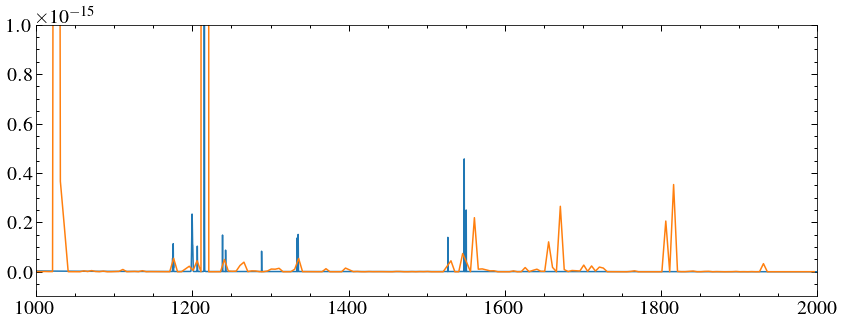

In [77]:
plt.plot(overlap_w, combined+lya_f_new)
plt.plot(w,f)
plt.xlim(1000, 2000)
plt.ylim(-1e-16, 1e-15)

What about the STIS CCD spectrum for the gap?

In [78]:
ccd = '../STIS/odlm41010_sx1.fits'
data = fits.getdata(ccd)[0]

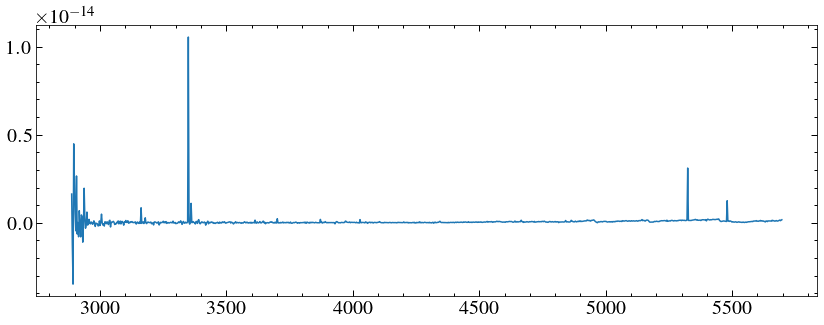

In [79]:
plt.plot(data['WAVELENGTH'], data['FLUX'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


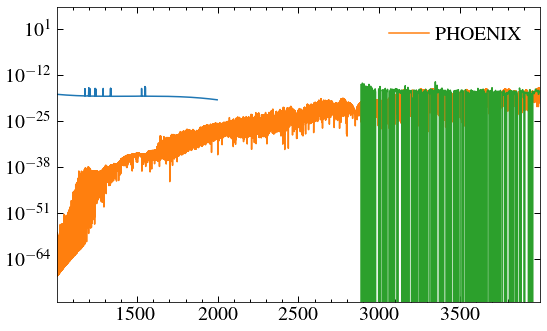

In [80]:
plt.figure(figsize=(8,5))
#plt.step(w,f/5, where='mid', label='DEM')
plt.plot(mw, lines_mod(mw)+10**nfit(mw))
plt.plot(pw, pf, label='PHOENIX')
plt.plot(data['WAVELENGTH'], data['FLUX'])
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()

In [81]:
ws, fs, es, dqs= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']


(0, 2.5e-16)

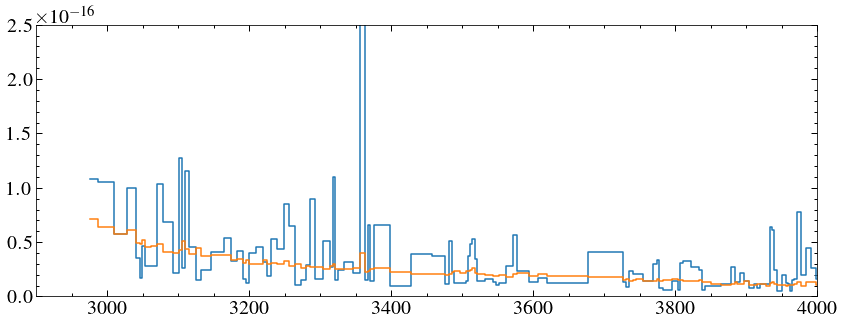

In [82]:
plt.step(ws[dqs==0],fs[dqs==0], where='mid')
plt.step(ws[dqs==0], es[dqs==0], where='mid')
plt.xlim(2900, 4000)
plt.ylim(0, 0.25e-15)

Ok looks reasonable- can we fit to that?

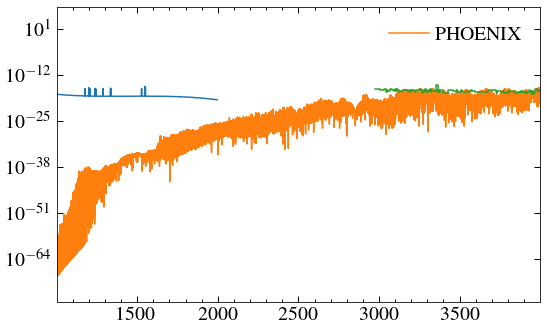

In [83]:
plt.figure(figsize=(8,5))
#plt.step(w,f/5, where='mid', label='DEM')
plt.plot(mw, lines_mod(mw)+10**nfit(mw))
plt.plot(pw, pf, label='PHOENIX')
plt.step(ws[dqs==0],fs[dqs==0], where='mid')
#plt.step(wo, fo)
plt.yscale('log')
plt.xlim(1001,3999)
plt.tight_layout()
plt.legend()

In [84]:
wclean, fclean = ws[dqs==0],fs[dqs==0]

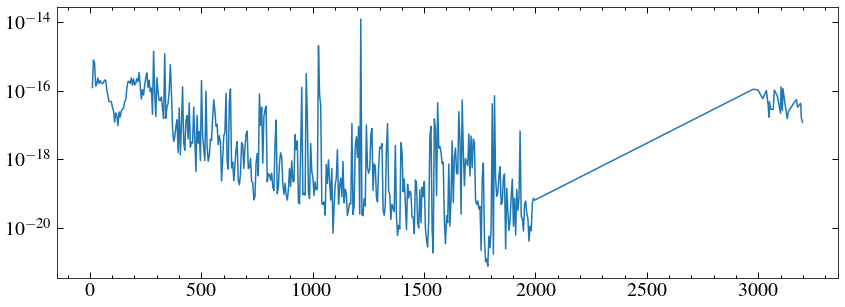

In [137]:
#w, f, bin_el, bin_eu = data['Wavelength'], data['Bin-Integrated Flux'], data['Lower_Error_16'], data['Upper_Error_84']
mask1 = w > 10
mask2 = wclean < 3200 
#nfit = fitter(n_init, w[mask],np.log10(f[mask]))
w2fit, f2fit = np.concatenate((w[mask1], wclean[mask2])), np.concatenate((f[mask1]/5, fclean[mask2]))
plt.plot(w2fit, f2fit)
plt.yscale('log')

In [138]:
nfit = fitter(n_init, w2fit,np.log10(f2fit))


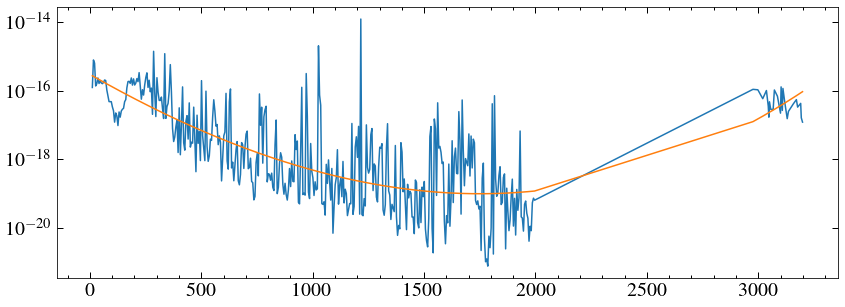

In [139]:
plt.plot(w2fit, f2fit)
plt.plot(w2fit, 10**nfit(w2fit))
plt.yscale('log')

(1001, 3999)

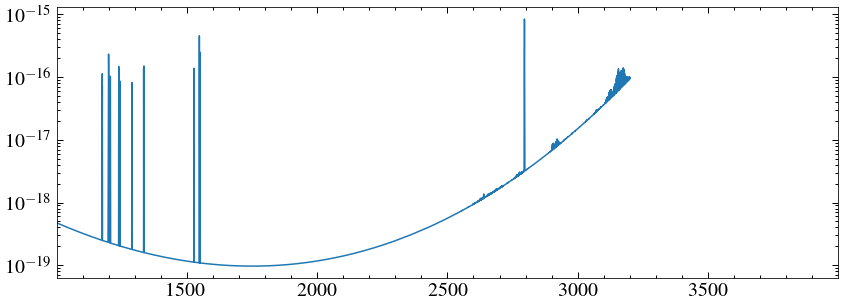

In [140]:
overlap_mask = (pw >=1000) & (pw <= 3200)
overlap_model = lines_mod(pw[overlap_mask]) + 10**nfit(pw[overlap_mask])
overlap_w, overlap_p = pw[overlap_mask], pf[overlap_mask]
combined = overlap_model+overlap_p
plt.plot(overlap_w, combined)
#plt.plot(pw, pf, label='PHOENIX', zorder=-1)
plt.yscale('log')
plt.xlim(1001,3999)

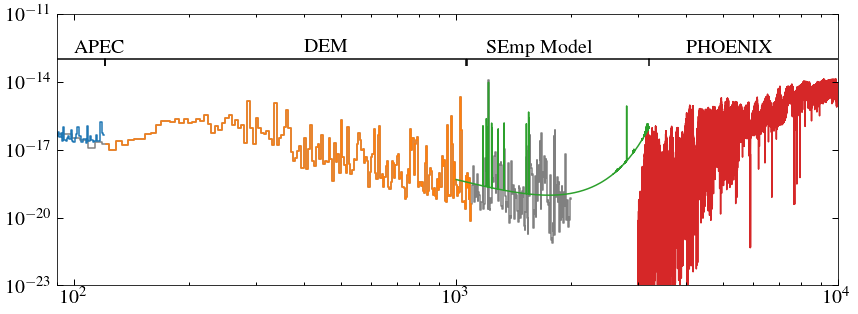

In [144]:
plt.step(apec['Wave'], apec['FLUX'], where='mid')
dem_mask = (w > apec['Wave'][-1]) & (w < 1100)
plt.step(w[dem_mask], f[dem_mask]/5, where='mid')
#lya_mask = (overlap_w < lyaw[0]) | (overlap_w > lyaw[-1])
#plt.plot(overlap_w[lya_mask], combined[lya_mask])
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(overlap_w)
plt.plot(overlap_w, combined+lya_f_new)
#plt.plot(lyaw, lyaf)
p_mask = pw > 3000
plt.plot(pw[p_mask], pf[p_mask], zorder=-1)
plt.step(w,f/5, zorder=-5, c='0.5', where='mid')
plt.xscale('log')
plt.yscale('log')
plt.xlim(90, 10000)
#plt.errorbar((15,60),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
#plt.annotate('XMM', (20, 2e-13))

plt.errorbar((60,120),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('APEC', (100, 2e-13))

plt.errorbar((120,1060),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('DEM', (400, 2e-13))

plt.errorbar((1068, 3200),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('SEmp Model', (1200, 2e-13))

plt.errorbar((3200, 54963),(1e-13, 1e-13), yerr= [[0,5e-14],[0,0]], c ='k')
plt.annotate('PHOENIX', (4000, 2e-13))

plt.ylim(1e-23, 1e-11)
plt.savefig('SEmp_eg_w_comp.png', dpi= 150)

In [117]:
apec['WAVE'][-1]

119.8